# Gaussian Process Latent Variable Models

The Gaussian process latent variable model (GPLVM) <strong data-cite="lawrence2003gaussian"></strong> employs GPs to learn a low-dimensional latent space representation of a high-dimensional, unsupervised dataset. Within this notebook, we use 3-phase oil flow data whose use is demonstrated in [GPFlow's GPLVM notebook](https://gpflow.github.io/GPflow/2.5.2/notebooks/basics/GPLVM.html).

In [1]:
import io

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

import numpy as np
import optax as ox
import requests
from jax import jit
from jaxutils import Dataset
from sklearn.decomposition import PCA

import jax.random as jr
import jax.numpy as jnp

import io

import mogpjax as mgpx

from jax.config import config

config.update("jax_enable_x64", True)

key = jr.PRNGKey(123)

response = requests.get(
    "https://github.com/GPflow/GPflow/blob/develop/doc/sphinx/notebooks/advanced/data/three_phase_oil_flow.npz?raw=true"
)
response.raise_for_status()
data = np.load(io.BytesIO(response.content))
labels = jnp.asarray(data["labels"])
observations = jnp.asarray(data["Y"])

## Data

The [3-Phase Oil Flow Data](https://inverseprobability.com/3PhaseData) contains 100, 12-dimensional observations with a three-levelled categorical label. Each observation corresponds to measurements made of an oil, water and gas pipeline and the corresponding label describes whether the measurement was made in a 1) horizontally stratified, 2) nested annular, or 3) homogenous mixture flow, configuration.

## Model specification

GPLVMs use a set of $Q$ Gaussian process $(f_1, f_2, \ldots, f_Q)$ to project from the latent space $\mathbf{X}\in\mathbb{R}^{N\times Q}$ to the observed dataset $\mathbf{Y}\in\mathbb{R}^{N\times D}$ where $Q\ll D$. The hierarchical model can then be written as
$$\begin{align}
p(\mathbf{X}) & = \prod_{n=1}^N \mathcal{N}(\mathbf{x}_{n}\mid\mathbf{0}, \mathbf{I}_Q) \\
p(\mathbf{f}\mid \mathbf{X}, \mathbf{\theta}) & = \prod_{d=1}^{D} \mathcal{N}(\mathbf{f}_{d}\mid \mathbf{0}, \mathbf{K}_{\mathbf{ff}}) \\
p(\mathbf{Y}\mid\mathbf{f}, \mathbf{X}) & = \prod_{n=1}^{N}\prod_{d=1}^{D}\mathcal{N}(y_{n, d}\mid f_d(\mathbf{x}_n), \sigma^2)
\end{align}
$$
where $\mathbf{f}_d = f_d(\mathbf{X})$.

In [2]:
from coinem.kernels import AutoKernel
from dataclasses import dataclass
from jaxtyping import Float, Array

@dataclass
class TwoArdRBF(AutoKernel):
    """Auto diff / vmap RBF kernel.

    Args:
        h (Float[Array, "1"]): Bandwidth parameter if median_trick is False. Defaults to 1.0.
    """

    h: Float[Array, "2"] = jnp.array([1.0 , 1.0])
    v: Float[Array, "1"] = jnp.array([1.0])

    def __call__(
        self, xi: Float[Array, "D"], yi: Float[Array, "D"]
    ) -> Float[Array, "1"]:
        """Compute kernel between two points.

        Args:
            xi (Float[Array, "D"]): First point.
            yi (Float[Array, "D"]): Second point.

        Returns:
            Float[Array, "1"]: Kernel value.
        """
        return (self.v * jnp.exp(-0.5 * jnp.sum((xi - yi)/self.h) ** 2)).squeeze()     

/Users/danieldodd/miniconda3/lib/python3.10/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [12]:
from coinem.dataset import Dataset
from coinem.model import AbstractModel
from coinem.kernels import AutoRBF
from jaxtyping import Float, Array

import tensorflow_probability.substrates.jax.distributions as tfd
from dataclasses import dataclass

@dataclass
class GPLVM(AbstractModel):

    def log_prob(self, latent: Float[Array, "P D"], theta: Float[Array, "2"], data: Dataset) -> Array:

        latent = latent.reshape(obs_pca.shape)

        y = data.y
        n = y.shape[0]

        log_prior_x = tfd.Normal(
            loc=theta[4], 
            scale=jnp.exp(theta[5]),
        ).log_prob(latent.flatten()).sum()
    

        # Σ = (Kxx + Io²)
        kernel = TwoArdRBF(h = jnp.exp(theta[:2]), v = jnp.exp(theta[2]))
        Kxx = kernel.K(latent) + jnp.eye(n) * (jnp.exp(theta[3]) + 1e-6)

        mll = tfd.MultivariateNormalFullCovariance(
            loc=jnp.zeros(n),
            covariance_matrix=Kxx,
        ).log_prob(y.T).sum()
        

        return log_prior_x + mll


latent_dim = 2
N = 100 # Number of particles

key = jr.PRNGKey(123)

obs_pca = jnp.asarray(PCA(n_components=2).fit_transform(observations))

X0 = tfd.MultivariateNormalDiag(
            loc=jnp.zeros(latent_dim), 
            scale_diag= 1.0 * jnp.ones(latent_dim)
        ).sample(seed=key, sample_shape=(N, observations.shape[0],)) + obs_pca

X0 = X0.reshape((N, -1))

theta0 = jnp.array([0.0, 0.0, 0.0, -4.0, 0.0, 0.0])


model = GPLVM()
data = Dataset(y=observations)

In [13]:
from coinem.zoo import coin_svgd

K = 500

x_coin, theta_coin = coin_svgd(model, data, X0, theta0, K)

In [14]:
latent = x_coin[-1]

res = latent.reshape(N, *obs_pca.shape)

## Latent space visualisation

With optimisation complete, we can now visualise our latent space. To do this, we'll simply plot the 2D coordinate that has been learned for each observation and colour it by oil's tranportation type. We should note that this flow-type variable has been used only for visualisation and was not part of the matrix that we have constructed a latent representation of.

### PCA

[Text(0.5, 0, 'Latent Coordinate 1'),
 Text(0, 0.5, 'Latent Coordinate 2'),
 Text(0.5, 1.0, 'Latent Space')]

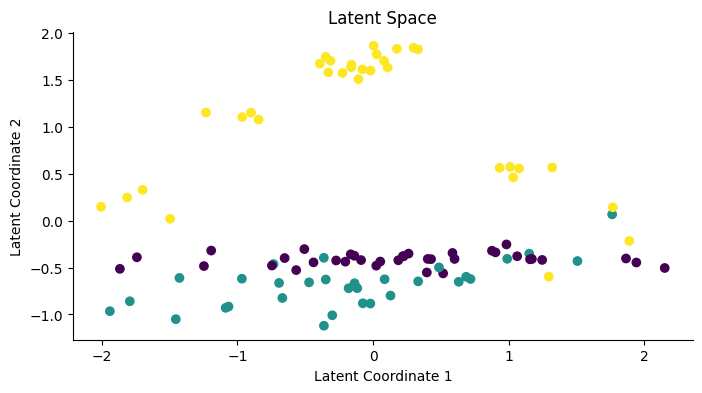

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(obs_pca[:, 0], obs_pca[:, 1], c=labels)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set(xlabel="Latent Coordinate 1", ylabel="Latent Coordinate 2", title="Latent Space")

### Coin

[Text(0.5, 0, 'Latent Coordinate 1'),
 Text(0, 0.5, 'Latent Coordinate 2'),
 Text(0.5, 1.0, 'Latent Space')]

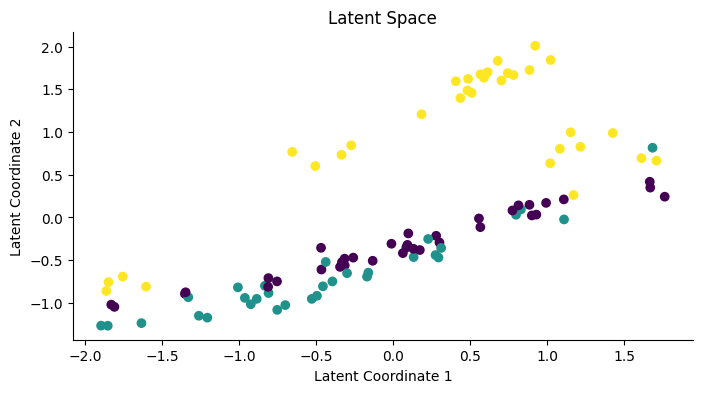

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(res[:, :, 0].mean(0), res[:, :, 1].mean(0), c=labels)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set(xlabel="Latent Coordinate 1", ylabel="Latent Coordinate 2", title="Latent Space")